In [5]:
# imports
import os
import numpy as np
import pickle
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm
import dask
import dask.array as da
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from sklearn.metrics import pairwise_distances
from IPython.display import display
import matplotlib.pyplot as plt




### How Does Feature Extraction Work?

- **ResNet50** is a convolutional neural network (CNN) pretrained on the ImageNet dataset, which contains millions of images across thousands of categories.
- It processes the image through multiple layers to generate a high-dimensional vector (embedding) that represents the image's features.
- The embedding is a high-dimensional vector.
- The layers in the network apply convolutional filters to the input image, capturing local patterns such as edges, textures, and simple shapes.
- The pooling layers downsample the feature maps, reducing their dimensionality and making the model more computationally efficient.
- Fully connected layers at the end would normally classify the image based on the extracted features.
- For feature extraction, you use the output of the avg-pool layer.
- The output is a 2048-dimensional vector that captures a summary of the image's high-level features.

### What Does the Model Take into Consideration?

- **Edges and corners**: Simple patterns at lower layers.
- **Textures**: Patterns like fabric textures or foliage.
- **Shapes and object parts**: Intermediate layers capture shapes and parts of objects.
- **Objects and scenes**: Higher layers capture complex objects and their arrangements within scenes.

In [6]:
# Load the ResNet50 model pre-trained on ImageNet (taktes around 2 sec)
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)



### How does the preprocessing work and why is it necessary?

- The image gets loaded and then preprocessed to match the format of the ResNet50 model.
- This involves resizing the picture to 224x224 pixels, normalizing the pixel values, and adding an extra dimension.




In [7]:
# Function to extract embedding with error handling
def extract_embedding(img_path, model):
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load the image
        img_data = image.img_to_array(img)  # Convert the image to an array
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)  # Preprocess the image to match the input format from ResNet50
        embedding = model.predict(img_data)
        return embedding.flatten()  # Return the flattened result
    except Exception as error:
        print(f"Error processing {img_path}: {error}")
        return None

# Function to get all image paths in the folder
def get_image_paths(main_folder):
    image_paths = []
    for root, _, files in os.walk(main_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                image_paths.append(full_path)
    return image_paths


# Extract embeddings for all images in the directory with logging and progress bar
def extract_and_store_embeddings(image_paths, model, checkpoint_dir, batch_size=32, checkpoint_interval=50000):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    embeddings = []
    valid_image_paths = []

    start_index = 0

    # Check if there is a checkpoint to resume from
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')])
    if checkpoint_files:
        last_checkpoint = checkpoint_files[-1]
        try:
            with open(os.path.join(checkpoint_dir, last_checkpoint), 'rb') as f:
                data = pickle.load(f)
                if len(data) == 3:
                    start_index, embeddings, valid_image_paths = data
                    print(f"Resuming from checkpoint {last_checkpoint}")
                else:
                    print(f"Unexpected checkpoint format in {last_checkpoint}. Starting from scratch.")
        except Exception as e:
            print(f"Error loading checkpoint {last_checkpoint}: {e}. Starting from scratch.")
    
    @delayed
    def process_batch(batch, batch_index):
        batch_embeddings = []
        batch_valid_image_paths = []
        for img_path in batch:
            embedding = extract_embedding(img_path, model)
            if embedding is not None:
                batch_embeddings.append(embedding)
                batch_valid_image_paths.append(img_path)
        
        # Save checkpoint at intervals
        if (batch_index + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{batch_index + 1}.pkl")
            with open(checkpoint_path, 'wb') as f:
                pickle.dump((batch_index + 1, embeddings + batch_embeddings, valid_image_paths + batch_valid_image_paths), f)
            print(f"Saved checkpoint at batch index {batch_index + 1}")
        
        return batch_embeddings, batch_valid_image_paths

    # Create batches
    batches = [image_paths[i:i + batch_size] for i in range(start_index, len(image_paths), batch_size)]

    # Process batches in parallel
    results = [process_batch(batch, i + start_index) for i, batch in enumerate(batches)]
    results = compute(*results)

    # Combine results
    all_embeddings = np.concatenate([result[0] for result in results])
    all_valid_image_paths = sum([result[1] for result in results], [])

    if len(all_embeddings) == 0:
        raise ValueError("No valid embeddings were extracted. Check the image paths and processing.")
    return all_embeddings, all_valid_image_paths

# Function to find similar images
def find_similar_images(input_img_path, model, embeddings, image_paths, top_n=5):
    input_embedding = extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    indices = np.argsort(similarities)[::-1][:top_n] # sort by similarity
    similar_images = [(image_paths[i], similarities[i]) for i in indices]
    return similar_images

# Save embeddings and image paths
def save_embeddings_and_paths(embeddings, image_paths, embeddings_path, image_paths_path):
    with open(embeddings_path, 'wb') as f:
        pickle.dump(embeddings, f)  # Write embeddings in pickle file
    with open(image_paths_path, 'wb') as f:
        pickle.dump(image_paths, f)  # Write image_paths in pickle file

# Load embeddings and image paths
def load_embeddings_and_paths(embeddings_path, image_paths_path):
    with open(embeddings_path, 'rb') as f:
        embeddings = pickle.load(f)
    with open(image_paths_path, 'rb') as f:
        image_paths = pickle.load(f)
    return embeddings, image_paths

# Function to display images
def display_images_from_paths(image_paths, target_size=(150, 150)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, path in zip(axes, image_paths):
        try:
            image = Image.open(path)
            image = image.resize(target_size, Image.LANCZOS)
            ax.imshow(image)
            ax.axis('off')
        except Exception as e:
            print(f"Error opening image {path}: {e}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

### How Does the Similarity Calculation Work?

- Cosine similarity measures the cosine of the angle between two vectors, providing a value between -1 (opposite) and 1 (the same).
- Cosine similarity is useful for comparing high-dimensional vectors because it measures the orientation of the vectors rather than their magnitude.
- This is beneficial because vectors might have different magnitudes but still represent similar content.

### What is special about the cosine similarity?
- focuses on the direction of the vectors, which means two vectors with the same direction but different magnitudes will be considered similar
- cosine similarity remains effective because it normalizes the vectors to unit length before measuring the angle between them


In [8]:
main_folder = 'C:\\Users\\lucas\\OneDrive - Hochschule Düsseldorf\\Uni_Drive\\DIV2k'
embeddings_path = 'embeddings.pkl'
image_paths_path = 'image_paths.pkl'
checkpoint_dir = "C:\\Users\\lucas\\OneDrive\\Documents\\Uni\\Sommersemester2024\\BigDataEngineering\\Foto_Projekt\\FindPicture\\checkpoint_dir"

if not os.path.exists(embeddings_path) or not os.path.exists(image_paths_path):
    image_paths = get_image_paths(main_folder)
    with ProgressBar():
        embeddings, valid_image_paths = extract_and_store_embeddings(image_paths, model, checkpoint_dir)
    save_embeddings_and_paths(embeddings, valid_image_paths, embeddings_path, image_paths_path)
else:
    embeddings, valid_image_paths = load_embeddings_and_paths(embeddings_path, image_paths_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0416.png, Similarity: 0.71
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0268.png, Similarity: 0.70
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0180.png, Similarity: 0.56
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0488.png, Similarity: 0.55
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0494.png, Similarity: 0.54


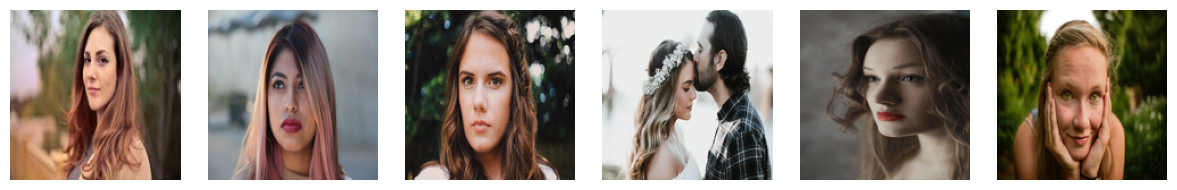

In [11]:
# set paths and find 
input_img_path = "C:\\Users\\lucas\\Downloads\\Frau.jpg"
similar_images = find_similar_images(input_img_path, model, embeddings, valid_image_paths, top_n=5)

top_5_paths = []
top_5_paths.append(input_img_path)
# Display similar images
for img_path, similarity in similar_images:
    print(f"Image: {img_path}, Similarity: {similarity:.2f}")
    top_5_paths.append(img_path)
    
# Display the images
display_images_from_paths(top_5_paths)


In [ ]:
# This code takes arouund 200 seconds for 1000 images. 
# this would be a time of 27 hours for 500.000 images

In [12]:
print(embeddings[1])
print(f"The shape of the embedding is {embeddings.shape}")
print(f"The max value of the embedding array is {np.max(embeddings)} and the min is {np.min(embeddings)}")
print(f"There are {len(valid_image_paths)} image paths")
assert(len(valid_image_paths) == embeddings.shape[0])

[1.1424953  0.01408025 0.24473271 ... 0.16306274 0.18841374 0.58192897]
The shape of the embedding is (901, 2048)
The max value of the embedding array is 28.174291610717773 and the min is 0.0
There are 901 image paths


: 

## Finding the closest image to 5 input images. 

Steps in the computation (look further up to know how the embeddings are calculated)
- Compute the mean value for each of the 2048 dimensions across all the input embeddings. 

### What happens if we input 5 completely random images?
- the algorithm will search for an image whose embedding is closest to this averaged embedding
- because the mean embedding is an aggregate of very diverse features, it might reuslt in selecting an image that contains some common elements or patterns found across the random images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0054.png, Similarity: 0.6545925736427307
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_valid_HR\DIV2K_valid_HR\0808.png, Similarity: 0.6399517059326172
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0218.png, Similarity: 0.6277354955673218
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0426.png, Similarity: 0.621422529220581
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0589.png, Similarity: 0.6181597709655762


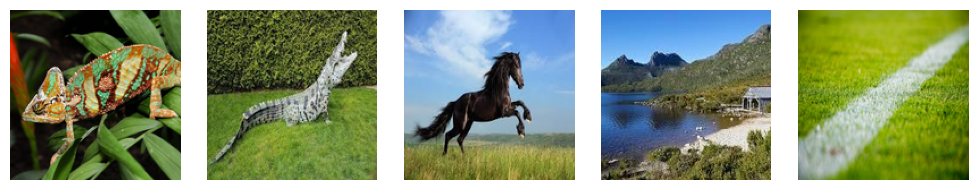

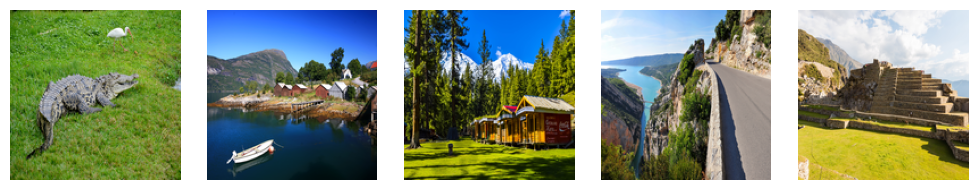

In [8]:

def average_embeddings(input_image_paths, model):
    embeddings = [extract_embedding(img_path, model) for img_path in input_image_paths]
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

def find_most_similar_to_group(input_image_paths, model, all_image_embeddings, all_image_paths, top_n=5):
    mean_embedding = average_embeddings(input_image_paths, model)
    similarities = cosine_similarity([mean_embedding], all_image_embeddings)[0]
    indices = np.argsort(similarities)[::-1][:top_n]
    similar_images = [(all_image_paths[i], similarities[i]) for i in indices]
    return similar_images

# Example usage
input_image_paths = [
    "C:\\Users\\lucas\\Downloads\\Kemelion.jpg",
    "C:\\Users\\lucas\\Downloads\\Krokodil.jpg",
    "C:\\Users\\lucas\\Downloads\\Pferd_auf_Wiese.jpg",
    "C:\\Users\\lucas\\Downloads\\images.jpg",
    "C:\\Users\\lucas\\Downloads\\Rasen.jpg"
]
top_5_paths_from_5_images = []
similar_images = find_most_similar_to_group(input_image_paths, model, embeddings, valid_image_paths)
for img_path, similarity in similar_images:
    print(f"Image: {img_path}, Similarity: {similarity}")
    top_5_paths_from_5_images.append(img_path)

display_images_from_paths(input_image_paths)
display_images_from_paths(top_5_paths_from_5_images)



### Other approach: Aggregated distance metric

Compute the distance from each candidate image to each of the 5 input images, then aggregate these distances.
The candidate image with the smallest aggregated distance is considered the closest match

### How is the distance calculated in the aggregated distance metric?

The aggregated distance metric is based on cosine similarity, which calculates the similarity between two vectors as the cosine of the angle between them
Formula for the cosine similarity: (A * B) / (||A|| x ||B||)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_valid_HR\DIV2K_valid_HR\0808.png, Aggregated Distance: 0.43927082419395447
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0054.png, Aggregated Distance: 0.4371415972709656
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0218.png, Aggregated Distance: 0.4256919324398041
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0426.png, Aggregated Distance: 0.41811156272888184
Image: C:\Users\lucas\OneDrive - Hochschule Düsseldorf\Uni_Drive\DIV2k\DIV2K_train_HR\DIV2K_train_HR\0002.png, Aggregated Distance: 0.4162138104438782


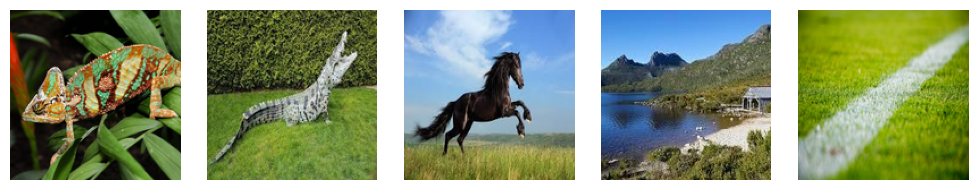

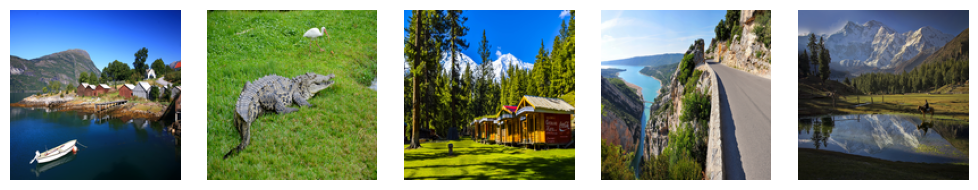

In [11]:
def aggregate_distances(input_image_paths, model, all_image_embeddings, all_image_paths, top_n=5):
    input_embeddings = [extract_embedding(img_path, model) for img_path in input_image_paths]
    aggregated_distances = []

    for i, candidate_embedding in enumerate(all_image_embeddings):
        distances = [cosine_similarity([candidate_embedding], [input_embedding])[0][0] for input_embedding in input_embeddings]
        aggregated_distance = np.mean(distances)
        aggregated_distances.append((all_image_paths[i], aggregated_distance))

    aggregated_distances.sort(key=lambda x: x[1], reverse=True)
    return aggregated_distances[:top_n]

# Example usage
input_image_paths = [
    "C:\\Users\\lucas\\Downloads\\Kemelion.jpg",
    "C:\\Users\\lucas\\Downloads\\Krokodil.jpg",
    "C:\\Users\\lucas\\Downloads\\Pferd_auf_Wiese.jpg",
    "C:\\Users\\lucas\\Downloads\\images.jpg",
    "C:\\Users\\lucas\\Downloads\\Rasen.jpg"
]

similar_images = aggregate_distances(input_image_paths, model, embeddings, valid_image_paths)
scnd_method_top5 = []
for img_path, distance in similar_images:
    print(f"Image: {img_path}, Aggregated Distance: {distance}")
    scnd_method_top5.append(img_path)

display_images_from_paths(input_image_paths)
display_images_from_paths(scnd_method_top5)
    


In [ ]:
# In order to see the runtime 
snakeviz profiling_results.prof
